* https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
* https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21
* https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/

In [83]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from ggplot import *
%matplotlib inline

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD

import re, nltk, spacy, gensim

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [84]:
car_review = pd.read_csv('car_review.csv', index_col=0)

In [85]:
car_review.head()

,Rating,Year,Review,Brand
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/


In [86]:
car_review.Rating.value_counts()

5    14704
4     3211
3      730
2      313
1      284
Name: Rating, dtype: int64

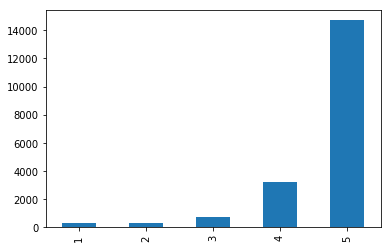

In [87]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

* Reviews are skewed towards positive

# Cleaning data and retrive features

### Car

In [88]:
car_review['Car'] = car_review.Brand.map(lambda x: x.split('/')[0])
car_review['Car_Year'] = car_review['Car'].map(lambda x: x.split('-')[-1])
car_review['Car_test'] = car_review['Car'].map(lambda x: x.split('-')[:-1])
car_review['Car_Make'] = car_review['Car_test'].map(lambda x: x[0])
car_review['Car_Model'] = car_review['Car_test'].map(lambda x: x[-1])

In [89]:
car_review.drop(['Car_test'], axis=1, inplace=True)

In [90]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


### Reviews

In [91]:
car_review['Review'] = car_review['Review'].map(lambda x: x.rstrip().lstrip())

In [92]:
car_review['Review'].head()

1    This is what I've bought Saturday:\n2012 Dodge...
2    I just got my Special Order wiith my name on w...
3    About 2 months ago I purchased a new Dodge Cha...
4    We bought a tungsten metallic SXT-Plus Charger...
5    I have a 2012 Dodge Charger R/T Plus AWD in re...
Name: Review, dtype: object

### Remove duplicate review
* There are some duplicate reviews in the dataset

In [93]:
car_review.shape

(19242, 8)

In [94]:
car_review.Review.nunique()

10821

In [95]:
car_review.Review.value_counts().head(5)

A solid compact sedan. I owned a Civic years ago, and I like the emergency brake redesign. The gas cap is gone, and the lid over the gas fill intake locks when the doors lock, and unlocks when the doors unlock. This makes a lot of sense.    52
I am very happy with my purchase. No buyers remorse at all. Fast, fun, reliable and comfortable! Would highly recommend this car to anyone. You will not find more bang for you buck.                                                            52
Excellent car. Excellent performance and very stylish. Handles excellent on the road. When you need the power this car has it with no problem.                                                                                                   50
This is my first new car and I am happy with the comfort and look of the car.  The Civic Hatchback is great to handle and the technical aspects of the car are easy to understand.                                                               50
This car is great for yo

In [96]:
car_review=car_review.drop_duplicates(subset=['Review'])

In [97]:
print('Number of unique reviews: ', car_review.Review.nunique())
print('Shape of the dataset: ', car_review.shape)

Number of unique reviews:  10821
Shape of the dataset:  (10821, 8)


In [98]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,This is what I've bought Saturday:\n2012 Dodge...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,I just got my Special Order wiith my name on w...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,About 2 months ago I purchased a new Dodge Cha...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,We bought a tungsten metallic SXT-Plus Charger...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,I have a 2012 Dodge Charger R/T Plus AWD in re...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


In [99]:
car_review.Rating.value_counts()

5    7815
4    1943
3     538
2     273
1     252
Name: Rating, dtype: int64

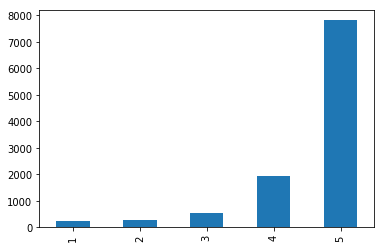

In [100]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

In [101]:
pd.crosstab(index=car_review.Rating, columns="count")/pd.crosstab(index=car_review.Rating, columns="count").sum()

col_0,count
Rating,
1,0.023288
2,0.025229
3,0.049718
4,0.179558
5,0.722207


### Create positive & negative tag 

In [102]:
car_review['tag'] = car_review['Rating'].map(lambda x:0 if x==5 else 1)

In [103]:
car_review['tag'].value_counts(sort=False)

0    7815
1    3006
Name: tag, dtype: int64

* I tag the reviews that the users not fully satisfied with the car.
#### 1: negative;
#### 0: positive.

# Topic Modeling

## 1. Removing new line characters and distracting single quotes

In [23]:
# Remove new line characters
data = [re.sub('\s+', ' ', i) for i in car_review.Review]
# Remove distracting single quotes
data = [re.sub("\'", "", i) for i in data]

## 2. Tokenize and Clean-up using gensim’s simple_preprocess()

In [25]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

In [26]:
data_words = list(sent_to_words(data))

# print(data_words[:1])

## 3. Lemmatization
* Lemmatization is a process where we convert words to its root word.
* For example: ‘Studying’ becomes ‘Study’, ‘Meeting becomes ‘Meet’, ‘Better’ and ‘Best’ becomes ‘Good’.
* The advantage of this is, we get to reduce the total number of unique words in the dictionary. As a result, the number of columns in the document-word matrix will be denser with lesser columns.

You can expect better topics to be generated in the end.

In [27]:
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

In [28]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

['be what have buy saturday dodge charger blackberry pearl raylle package navigation system backup camera spoiler sunroof cloth seat  review trade  dodge charger sxt leather do not think would like cloth seat be okay everything inside  car be black even ceiling so would not be able see stain major car drive very well absolutely love weight steering wheel  pretty quiet inside road visibility be good find thinking excuse just drive somewhere have also discover sport mode which make very thrilling drive make charger feel sound tiny little sport car love push button start do not even need take key  pocket now problem will come summer time when will not have jacket put  key be guy so ill probably have buy belt clip clip remote start be such great feature as well overall car still have get use cloth seat honestly feel good leather be think leather give cloth seat try may not even want purchase only thing see be problem be find comfy driving position do not have power adjustable pedal one  ch

## 4. Create the Document-Word matrix

* Count Vectorizer

In [29]:
vectorizer = CountVectorizer(analyzer='word',  
                             max_df=0.95,
                             min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [30]:
data_vectorized.todense().shape

(10821, 3466)

* TF-IDF Vectorizer

In [31]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',       
                             max_df=0.95,
                            min_df=5,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

tfidf_data_vectorized = tfidf_vectorizer.fit_transform(data_lemmatized)

In [32]:
tfidf_data_vectorized.todense().shape

(10821, 3466)

## 5. Check the Sparsicity

* Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix, that is data_vectorized.
* Since most cells in this matrix will be zero, I am interested in knowing what percentage of cells contain non-zero values.

* Count Vectorizer

In [33]:
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Count Vectorizer Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Count Vectorizer Sparsicity:  0.7322535901718746 %


* TF-IDF Vectorizer

In [34]:
# Materialize the sparse data
tfidf_data_dense = tfidf_data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Count Vectorizer Sparsicity: ", ((tfidf_data_dense > 0).sum()/tfidf_data_dense.size)*100, "%")

Count Vectorizer Sparsicity:  0.7322535901718746 %


## 6. Build LDA model with sklearn
* Everything is ready to build a Latent Dirichlet Allocation (LDA) model. Let’s initialise one and call fit_transform() to build the LDA model.

* Count Vectorizer

In [35]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


* TF-IDF Vectorizer

In [36]:
# Build LDA Model
tfidf_lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
tfidf_lda_output = tfidf_lda_model.fit_transform(tfidf_data_vectorized)

print(tfidf_lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


## 7. Diagnose model performance with perplexity and log-likelihood
* A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good. Let’s check for our model.

* Count Vectorizer

In [37]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
print(lda_model.get_params())

Log Likelihood:  -2227611.600980399
Perplexity:  878.1153085972826
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 20, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


* TF-IDF Vectorizer

In [38]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", tfidf_lda_model.score(tfidf_data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", tfidf_lda_model.perplexity(tfidf_data_vectorized))

# See model parameters
print(tfidf_lda_model.get_params())

Log Likelihood:  -389638.29555575986
Perplexity:  4027.791891931383
{'batch_size': 128, 'doc_topic_prior': None, 'evaluate_every': -1, 'learning_decay': 0.7, 'learning_method': 'online', 'learning_offset': 10.0, 'max_doc_update_iter': 100, 'max_iter': 10, 'mean_change_tol': 0.001, 'n_components': 10, 'n_jobs': -1, 'n_topics': 20, 'perp_tol': 0.1, 'random_state': 100, 'topic_word_prior': None, 'total_samples': 1000000.0, 'verbose': 0}


Therefore, I choose Count Vectorizer preprocessing method.

## 8. GridSearch the best LDA model
* The most important tuning parameter for LDA models is n_components (number of topics). In addition, I am going to search learning_decay (which controls the learning rate) as well.
* Besides these, other possible search params could be learning_offset (downweigh early iterations. Should be > 1) and max_iter. These could be worth experimenting if you have enough computing resources.

In [56]:
# Define Search Param
search_params = {'n_components': [8, 10, 12, 15], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_components': [8, 10, 12, 15], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

## 9. The best topic model and its parameters

In [57]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 8}
Best Log Likelihood Score:  -760240.3357077558
Model Perplexity:  770.8574998777895


## Crate model with best parameters

In [62]:
best_lda_model = LatentDirichletAllocation(learning_decay=0.7, n_components=8)
best_lda_output = best_lda_model.fit_transform(data_vectorized)

In [63]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", best_lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", best_lda_model.perplexity(data_vectorized))

Log Likelihood:  -2188566.25755906
Perplexity:  779.7534131835474


## 10. The dominant topic in each document

* To classify a document as belonging to a particular topic, a logical approach is to see which topic has the highest contribution to that document and assign it.
* In the table below, I’ve greened out all major topics in a document and assigned the most dominant topic in its own column.

In [64]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()

In [65]:
print("\nTopics in LDA model:")
tf_feature_names = vectorizer.get_feature_names()
print_top_words(best_lda_model, tf_feature_names, 12)


Topics in LDA model:
Topic #0: mpg seat car highway drive mile road engine speed average transmission use
Topic #1: car great good gas mileage love comfortable drive look ride nice room
Topic #2: fusion light door subaru sentra screen radio standard touch base mirror turn
Topic #3: car need mile buy problem issue new service dealer meet nissan year
Topic #4: vehicle purchase chevy new cruze impala make experience sale buy thank car
Topic #5: car drive love look great good just feature feel buy mazda want
Topic #6: car honda toyota new buy year camry accord good make just sonata
Topic #7: tire phone low bluetooth audio work sound helpful free use paint surprise



In [66]:
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

In [67]:
# column names
topicnames = []
for topic_idx, topic in enumerate(best_lda_model.components_):
    topicnames.append("Topic #%d: " % topic_idx)

In [68]:
# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

In [69]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [70]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
df_document_topic.head()

,Topic #0:,Topic #1:,Topic #2:,Topic #3:,Topic #4:,Topic #5:,Topic #6:,Topic #7:,dominant_topic
Doc0,0.31,0.00,0.00,0.0,0.0,0.69,0.00,0.0,5
Doc1,0.11,0.00,0.03,0.0,0.0,0.42,0.44,0.0,6
Doc2,0.35,0.00,0.00,0.0,0.0,0.63,0.00,0.0,5
Doc3,0.11,0.22,0.00,0.0,0.0,0.66,0.00,0.0,5
Doc4,0.00,0.16,0.22,0.0,0.0,0.61,0.00,0.0,5


## 11. Review topics distribution across documents

In [72]:
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,1,3553
1,5,3337
2,0,1799
3,6,1109
4,3,653
5,4,229
6,2,101
7,7,40


## 12. Visualize the LDA model with pyLDAvis
* The pyLDAvis offers the best visualization to view the topics-keywords distribution.
* A good topic model will have non-overlapping, fairly big sized blobs for each topic. 

In [73]:
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=            Freq  cluster  topics           x           y
topic                                                    
5      23.584045        1       1 -209.886658  146.993240
0      20.621327        1       2  186.536697  230.663727
1      18.849116        1       3  179.892120 -174.401047
6      13.802898        1       4  -40.079025 -220.875107
3       7.586615        1       5  -31.811037  284.237091
2       6.546161        1       6   21.699841   30.763384
4       5.062151        1       7  280.751770   26.529325
7       3.947685        1       8 -213.505173  -77.803207, topic_info=     Category          Freq         Term         Total  loglift  logprob
term                                                                    
426   Default  18367.000000          car  18367.000000  30.0000  30.0000
1331  Default   5540.000000        great   5540.000000  29.0000  29.0000
3317  Default   2293.000000      vehicle   2293.000000  28.0000  28.0000
1970  Default   1792.000000          mpg   1792.000000  27.0000  27.0000
2010  Default   1716.000000         need   1716.000000  26.0000  26.0000
1794  Default   4097.000000         love   4097.000000  25.0000  25.0000
1261  Default   2788.000000          gas   2788.000000  24.0000  24.0000
1439  Default   1264.000000        honda   1264.000000  23.0000  23.0000
396   Default   2898.000000          buy   2898.000000  22.0000  22.0000
2020  Default   2679.000000          new   2679.000000  21.0000  21.0000
1914  Default   2046.000000         mile   2046.000000  20.0000  20.0000
1915  Default   2004.000000      mileage   2004.000000  19.0000  19.0000
2355  Default   1753.000000     purchase   1753.000000  18.0000  18.0000
559   Default   2378.000000  comfortable   2378.000000  17.0000  17.0000
3139  Default    617.000000         tire    617.000000  16.0000  16.0000
2329  Default    999.000000      problem    999.000000  15.0000  15.0000
3164  Default    938.000000       toyota    938.000000  14.0000  14.0000
2662  Default   2579.000000         seat   2579.000000  13.0000  13.0000
417   Default    848.000000        camry    848.000000  12.0000  12.0000
23    Default    878.000000       accord    878.000000  11.0000  11.0000
1305  Default   5257.000000         good   5257.000000  10.0000  10.0000
3452  Default   1824.000000         year   1824.000000   9.0000   9.0000
1621  Default    868.000000        issue    868.000000   8.0000   8.0000
2211  Default    449.000000        phone    449.000000   7.0000   7.0000
3429  Default   1037.000000         work   1037.000000   6.0000   6.0000
1423  Default    976.000000      highway    976.000000   5.0000   5.0000
489   Default    466.000000        chevy    466.000000   4.0000   4.0000
2579  Default   1046.000000         room   1046.000000   3.0000   3.0000
1797  Default    652.000000          low    652.000000   2.0000   2.0000
1782  Default   3221.000000         look   3221.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
2335   Topic8     42.104281      profile     42.974475   3.2116  -5.7306
2007   Topic8     38.865410    necessary     39.736257   3.2099  -5.8106
1553   Topic8     38.822394         info     39.693560   3.2098  -5.8118
979    Topic8     38.086976   electrical     38.957785   3.2094  -5.8309
2209   Topic8     37.466622   phenomenal     38.337317   3.2091  -5.8473
1544   Topic8     31.470743    indicator     32.341213   3.2048  -6.0217
3306   Topic8     31.120536        valve     31.991188   3.2044  -6.0329
1720   Topic8     30.784906  leatherette     31.656239   3.2041  -6.0437
1252   Topic8     30.664537          gal     31.535150   3.2040  -6.0476
617    Topic8    100.846011      connect    103.853456   3.2027  -4.8572
2211   Topic8    426.263965        phone    449.449602   3.1791  -3.4157
3139   Topic8    577.452285         tire    617.869442   3.1644  -3.1121
1615   Topic8     66.077003       iphone     69.745874   3.1780  -5.2799
2861   Topic8     6

## 13. See the Topic’s keywords

In [74]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,ability,able,abnormal,abs,absolute,absolutely,absorb,abundance,abundant,accelerate,...,yield,yokohama,york,young,youtube,yrs,zip,zippy,zone,zoom
Topic #0:,18.493316,30.565481,0.125424,0.125295,9.186892,0.125253,0.125460,0.125101,5.861103,135.052768,...,4.821030,0.125304,0.125242,0.125241,0.125133,18.861034,0.125347,0.125264,0.125420,0.125262
Topic #1:,18.001079,0.125191,0.125002,0.125183,0.125218,97.242439,0.125130,5.144827,0.125122,3.963158,...,0.125176,0.125022,0.125194,0.125331,0.125150,0.125187,28.882308,0.125247,0.125222,0.125154
Topic #2:,0.125272,0.125211,0.125195,0.125397,0.125214,0.125183,0.125107,0.125134,0.125178,0.159129,...,0.125047,0.125233,0.126291,0.125975,6.876942,0.156361,0.125388,0.125479,0.125401,0.125117
Topic #3:,0.125152,0.125239,6.889036,0.125158,0.125252,0.125196,0.125338,0.125048,0.125074,0.125169,...,0.125172,0.125327,3.370945,0.125243,0.125154,0.125533,0.125224,0.125158,0.125063,0.125113
Topic #4:,0.170652,84.785993,0.125402,16.057149,0.125282,0.125239,0.125180,0.125174,0.125081,0.125207,...,0.125517,0.125016,0.125124,0.125194,0.125486,0.125448,0.125297,0.125117,0.125352,0.125241


## 14. Top 15 keywords each topic

In [75]:
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=15)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14
Topic 0,mpg,seat,car,highway,drive,mile,road,engine,speed,average,transmission,use,good,driver,trip
Topic 1,car,great,good,gas,mileage,love,comfortable,drive,look,ride,nice,room,interior,reliable,feature
Topic 2,fusion,light,door,subaru,sentra,screen,radio,standard,touch,base,mirror,turn,impreza,control,model
Topic 3,car,need,mile,buy,problem,issue,new,service,dealer,meet,nissan,year,time,work,good
Topic 4,vehicle,purchase,chevy,new,cruze,impala,make,experience,sale,buy,thank,car,brand,salesman,satisfied
Topic 5,car,drive,love,look,great,good,just,feature,feel,buy,mazda,want,new,really,make
Topic 6,car,honda,toyota,new,buy,year,camry,accord,good,make,just,sonata,model,corolla,civic
Topic 7,tire,phone,low,bluetooth,audio,work,sound,helpful,free,use,paint,surprise,vehicle,noise,future


## 15. Predict the topics for a new piece of text

In [119]:
# Define function to predict topic for a given text document.
# nlp = spacy.load('en', disable=['parser', 'ner'])

def predict_topic(text):
    #     global sent_to_words
    global lemmatization
    
    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    print('The dominant topic of the content is Topic #', np.argmax(topic_probability_scores, axis=1)[0])
    return topic, topic_probability_scores

In [120]:
# Predict the topic
mytext = ["is perfect for me since it saves gas, is very comfortable and super easy to handle, its design I really like"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

The dominant topic of the content is Topic # 1
['car', 'great', 'good', 'gas', 'mileage', 'love', 'comfortable', 'drive', 'look', 'ride', 'nice', 'room', 'interior', 'reliable', 'feature']
[[0.01250526 0.74172002 0.01250285 0.01250075 0.0125     0.18326557
  0.0125034  0.01250215]]


In [121]:
# Predict the topic
mytext = ["The new Maxima is totally a 5 star car but make sure that you get the SV or SL models. The S model is not worth it. The cloth seats are not as comfortable as the leather seats!"]
topic, prob_scores = predict_topic(text = mytext)
print(topic)
print(prob_scores)

The dominant topic of the content is Topic # 5
['car', 'drive', 'love', 'look', 'great', 'good', 'just', 'feature', 'feel', 'buy', 'mazda', 'want', 'new', 'really', 'make']
[[0.00783661 0.00782508 0.00782053 0.0078177  0.00783425 0.94522408
  0.00782879 0.00781296]]


## 16. Cluster documents that share similar topics
* Devise an elbow curve to select the optimal number of clusters (k)

In [122]:
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=8, random_state=666).fit_predict(lda_output)

In [123]:
clusters.shape

(10821,)

In [131]:
N = range(1, 15)

kmeans = [KMeans(n_clusters=i) for i in N]

# kmeans

In [132]:
score = [kmeans[i].fit(lda_output).score(lda_output) for i in range(len(kmeans))]

score

[-2368.0046128703625,
 -1654.1426896355754,
 -1239.4526178616493,
 -1044.4096238147567,
 -930.4904125481432,
 -839.5883160264011,
 -775.7879464452885,
 -723.173855090236,
 -684.9083249886609,
 -650.2432705004367,
 -620.2385786981858,
 -591.9793434071776,
 -566.9830170507216,
 -544.4586238544317]

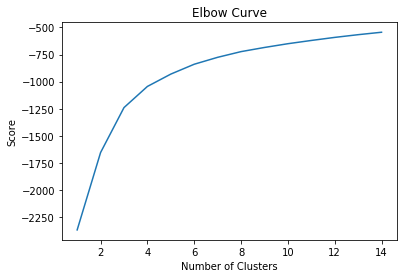

In [133]:
plt.plot(N,score)

plt.xlabel('Number of Clusters')

plt.ylabel('Score')

plt.title('Elbow Curve')

plt.show()